## Figures

- Figure 1 D,E
- Figure S1 A,B

## Required files

`model_dir = '/oak/stanford/groups/akundaje/avsec/basepair/data/processed/comparison/output/nexus,peaks,OSNK,0,10,1,FALSE,same,0.5,64,25,0.004,9,FALSE,[1,50],TRUE'`
- {model_dir}/calibrated_seq_model.pkl
- {model_dir}/history.csv
- Files in `ChIP-nexus.dataspec.yml`


## Output

`figures = f'{ddir}/figures/model-evaluation/chipnexus-bpnet/{exp}'`
- Figure 1D, Figure S1A
  - `{figures}/profiles/top-sum-max-count-{idx}-{interval_str}.pdf`
- Figure 1E
  - `{figures}/profile-metrics/auprc.pdf`
- Figure S1B
  - `{figures}/scatter/all.pdf`

In [7]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from basepair.imports import *
from basepair.extractors import bw_extract
from basepair.datasets import StrandedProfile
from basepair.preproc import AppendCounts
from basepair.config import valid_chr, test_chr
from basepair.plot.evaluate import regression_eval
from basepair.cli.evaluate import eval_profile
from basepair.exp.paper.config import *
import matplotlib.ticker as ticker
import warnings
warnings.filterwarnings("ignore")

paper_config() # Use matplotlib paper config

In [2]:
exp = 'nexus,peaks,OSNK,0,10,1,FALSE,same,0.5,64,25,0.004,9,FALSE,[1,50],TRUE'
gpu = 1

In [10]:
model_dir

PosixPath('/oak/stanford/groups/akundaje/avsec/basepair/data/processed/comparison/output/nexus,peaks,OSNK,0,10,1,FALSE,same,0.5,64,25,0.004,9,FALSE,[1,50],TRUE')

In [9]:
from basepair.config import get_data_dir, get_repo_root
rdir = get_repo_root()

# Common paths
model_dir = models_dir / exp
figures = f"{ddir}/figures/model-evaluation/chipnexus-bpnet/{exp}"

# Parameters
dataspec_file = rdir / "src/chipnexus/train/seqmodel/ChIP-nexus.dataspec.yml"
history_file = model_dir / "history.csv"
seq_width = 1000
num_workers = 10

## Get predictions

In [17]:
ds = DataSpec.load(dataspec_file)
tasks = list(ds.task_specs)

In [18]:
create_tf_session(gpu)

In [19]:
ls {model_dir}

activity/                                     log/
benchmark/                                    model.h5
calibrated.pkl                                note_params.json
calibrated_seqmodel.pkl                       null.deeplift.imp_score.h5
config.gin                                    perturbation-analysis/
config.gin.json                               perturbation-analysis-bak/
deeplift/                                     preds.test.pkl
deeplift.imp_score.h5                         seq_model.pkl
evaluation.valid.json                         test.pkl
events.out.tfevents.1552394698.sh-112-11.int  train.smk-benchmark.tsv
history.csv                                   wandb.json
imp_score_deeplift.smk-benchmark.tsv


In [20]:
from basepair.seqmodel import SeqModel
bpnet = SeqModel.load(model_dir / 'calibrated_seqmodel.pkl')

Instructions for updating:
`NHWC` for data_format is deprecated, use `NWC` instead


2019-07-19 15:38:05,744 [WARNING] From /users/avsec/bin/anaconda3/envs/chipnexus/lib/python3.6/site-packages/tensorflow/python/util/deprecation.py:497: calling conv1d (from tensorflow.python.ops.nn_ops) with data_format=NHWC is deprecated and will be removed in a future version.
Instructions for updating:
`NHWC` for data_format is deprecated, use `NWC` instead


Instructions for updating:
Use the retry module or similar alternatives.


2019-07-19 15:38:21,045 [WARNING] From /users/avsec/bin/anaconda3/envs/chipnexus/lib/python3.6/site-packages/tensorflow/contrib/learn/python/learn/datasets/base.py:198: retry (from tensorflow.contrib.learn.python.learn.datasets.base) is deprecated and will be removed in a future version.
Instructions for updating:
Use the retry module or similar alternatives.


In [21]:
profile_bias_pool_size=[1,50]  # Note: this is specific to the model

In [22]:
!rm {model_dir}/preds.test.pkl

In [23]:
# Get the predictions
if not os.path.exists(model_dir / "preds.test.pkl"):
    dl_test = StrandedProfile(ds, 
                              incl_chromosomes=test_chr, 
                              peak_width=seq_width,
                              shuffle=False,
                              target_transformer=AppendCounts(),
                              profile_bias_pool_size=profile_bias_pool_size)

    test = dl_test.load_all(num_workers=num_workers)
    y_true = test["targets"]
    y_pred = bpnet.predict(test['inputs'])
    write_pkl((test, y_pred), model_dir / "preds.test.pkl")

# Load predictions
test, y_pred = read_pkl(model_dir / "preds.test.pkl")
y_true = test['targets']

100%|██████████| 867/867 [00:30<00:00, 40.18it/s]


In [24]:
# Load the training data and compute the average profile
dl_train = StrandedProfile(ds, 
                           excl_chromosomes=test_chr + valid_chr, 
                           peak_width=seq_width,
                           shuffle=False)
train_data = dl_train.load_all(num_workers=num_workers)
avg_profile = {k.split("/")[1]: v.mean(axis=0) for k,v in train_data['targets'].items()}

100%|██████████| 2935/2935 [01:17<00:00, 37.97it/s]


## Profile plots (predicted vs observed)

- for each set of TF peaks (all non-overlapping) in the test set (chr1, chr8, chr9), choose two with most counts

In [36]:
from basepair.plots import plot_profiles
from basepair import samplers
from kipoi.data_utils import get_dataset_item
from kipoi.metadata import GenomicRanges
import pybedtools
from basepair.utils import flatten_list
from basepair.plot.tracks import plot_tracks, filter_tracks
from basepair.preproc import dfint_no_intersection
from pybedtools import BedTool

In [37]:
# Figure out valid indices (non-overlapping)
df_ranges = pd.DataFrame(test['metadata']['range'])[['chr', 'start','end']]
df_ranges_tasks = {t: df_ranges[test['metadata']['interval_from_task'] == t] for t in bpnet.tasks}
all_intervals = list(BedTool.from_dataframe(df_ranges))

o = dict()
for i,t in enumerate(bpnet.tasks):
    dft = df_ranges.iloc[test['metadata']['interval_from_task'] == t]
    if i == 0:
        o[t] = dft
    else:
        df_existing = pd.concat(list(o.values()), axis=0)
        o[t] = dft[dfint_no_intersection(dft, df_existing)]
valid_idx = pd.concat(list(o.values()), axis=0).index

valid_idx_bool = pd.Series(np.arange(len(df_ranges))).isin(valid_idx)

print("Fraction of non-overlapping peaks:", valid_idx_bool.mean())

Fraction of non-overlapping peaks: 0.5853139539077433


In [38]:
from genomelake.extractors import FastaExtractor
from basepair.preproc import resize_interval

In [39]:
input_seqlen = 1000 - bpnet.body.get_len_change()  - bpnet.heads[0].net.get_len_change()

In [41]:
# Check how much of the total counts is allocated at a single position
yt = sum([y_true[f'profile/{task}']
          for task in tasks])

(yt / yt.sum(axis=1, keepdims=True)).max(axis=(-1, -2)).max()

max_frac = (yt / yt.sum(axis=1, keepdims=True)).max(axis=(-1, -2))

max_pos = (yt ).max(axis=(-1, -2))
total_counts = (yt ).sum(axis=(-1, -2))
n_zeros = np.sum(yt == 0, axis=(-1, -2))

In [ ]:
from basepair.exp.paper.config import tf_colors

# Generate the right colors
colors = []
for task in bpnet.tasks:
    colors.append((tf_colors[task], tf_colors[task] + "80"))  # 80 add alpha=0.5
    colors.append((tf_colors[task], tf_colors[task] + "80"))  # 80 add alpha=0.5
    
def to_neg(track):
    """Use the negative sign for reads on the reverse strand
    """
    track = track.copy()
    track[:, 1] = - track[:, 1]
    return track    

In [3]:
from basepair.samplers import top_sum_count, top_max_count

In [45]:
def top_max_count(arr, end=10, start=0, keep=None):
    """
    Return indices where arr has the highest max(pos) + max(neg)

    Args:
      arr: can be an array or a list of arrays
      start: Where to start returning the values
      end: where to stop
    """
    if keep is None:
        keep = np.arange(len(arr))
    assert end > start
    # Top maxcount indicies
    return pd.Series(arr.max(1).sum(1))[keep].sort_values(ascending=False).index[start:end]

In [46]:
# Get the idx to test
idx_set = set()
for task in bpnet.tasks:
    keep = ((test['metadata']['interval_from_task'] == task) & valid_idx_bool &
            valid_idx_bool & ~((max_pos > 400) & (n_zeros > 1000))
            )
    idx_set.update(top_max_count(y_true[f'profile/{task}'],10,keep=keep))
    idx_set.update(top_sum_count(y_true[f'profile/{task}'],10,keep=keep))

In [ ]:
trim_edge = 300
xlim = [trim_edge, 1000 - trim_edge]
fig_width=get_figsize(0.5)[0]
rotate_y=90
fig_height_per_track=0.5
tasks = bpnet.tasks

for idx in idx_set:
    # get the interval for that idx
    r = get_dataset_item(test['metadata']['range'], idx)
    interval = pybedtools.create_interval_from_list([r['chr'], int(r['start']), int(r['end'])])
    interval_str = f"{interval.chrom}:{interval.start + trim_edge}-{interval.end - trim_edge}"

    # make prediction

    fe = FastaExtractor(ds.fasta_file)
    seq = fe([resize_interval(interval, input_seqlen, ignore_strand=True)])
    x = bpnet.neutral_bias_inputs(1000, 1000)
    x['seq'] = seq
    pred = bpnet.predict(x)


    # compile the list of tracks to plot
    viz_dict =flatten_list([[
        # Observed
        (f"{task}\nObs", to_neg(y_true[f'profile/{task}'][idx])),
        # Predicted
        (f"\nPred", to_neg(pred[f'{task}/profile'][0] * np.exp(pred[f'{task}/counts'][0]))),
    ] for task_idx, task in enumerate(tasks)])

    sl = slice(*xlim)
    # Get ylim
    ylim = []
    for task in tasks:
        m = y_true[f'profile/{task}'][idx][sl].max()
        ylim.append((-m,m))
        m = (pred[f'{task}/profile'][0] * np.exp(pred[f'{task}/counts'][0])).max()
        ylim.append((-m,m))

    fig = plot_tracks(filter_tracks(viz_dict, xlim),
                      title=interval_str,
                      fig_height_per_track=fig_height_per_track,
                      rotate_y=rotate_y,
                      use_spine_subset=True,
                      color=colors,
                      fig_width=fig_width,
                      ylim=ylim,
                      legend=False)
    fig.align_ylabels()
    sns.despine(top=True, right=True, bottom=True)
    os.makedirs(f"{figures}/profiles", exist_ok=True)
    fig.savefig(f"{figures}/profiles/top-sum-max-count-{idx}-{interval_str}.pdf")
    # fig.savefig(f"{figures}/profiles/top-sum-max-count-{idx}-{interval_str}.png")

### Replicate performance

In [26]:
rep_indices = [f'N{x:02d}' for x in np.arange(1, 21)]

In [27]:
reps = pd.read_csv("https://docs.google.com/spreadsheets/d/1PvHGy0P9_Yq0tZFw807bjadxaZHAYECE4RytlI9rdeQ/export?gid=0&format=csv")
reps = reps[reps.Mnemonic.isin(rep_indices)]

In [28]:
reps.head()

,Mnemonic,FTP Name,thenexus Name,Sample ID,Comments,Data Type,TF Name,Rep Number,Control Reps,QC report,Unique deduped reads,Held-out test,"#Rep-IDRpeaks (N1, N2, ..)",#IDR-optimal peaks (Np),Md5-hash-FASTQ,Md5-hash-IDRoptimal,Md5-bigwigs,Oak path peak,Oak path bw pos,Oak path bw neg
16,N01,mesc_oct4_nexus_1.fas...,NaN,NaN,NaN,chipnexus,oct4,1.0,NaN,http://mitra.stanford...,31M,False,8772.0,25849.0,459a81cf3075ea87d40b7...,NaN,NaN,NaN,NaN,NaN
17,N02,mesc_oct4_nexus_2.fas...,NaN,NaN,NaN,chipnexus,oct4,2.0,NaN,http://mitra.stanford...,50M,True,10548.0,25849.0,536a72cc5c79707e22073...,NaN,NaN,NaN,NaN,NaN
18,N03,mesc_oct4_nexus_3.fas...,NaN,NaN,NaN,chipnexus,oct4,3.0,NaN,http://mitra.stanford...,48M,True,5996.0,25849.0,9a3abcdf2be00d2e6a73e...,NaN,NaN,NaN,NaN,NaN
19,N04,mesc_oct4_nexus_4.fas...,NaN,NaN,NaN,chipnexus,oct4,4.0,NaN,http://mitra.stanford...,51M,False,7572.0,25849.0,ad16824c3e3eafe0475f4...,NaN,NaN,NaN,NaN,NaN
20,N05,mesc_oct4_nexus_5.fas...,NaN,NaN,NaN,chipnexus,oct4,5.0,NaN,http://mitra.stanford...,30M,True,8226.0,25849.0,f8cafa07687a9767146f0...,NaN,NaN,NaN,NaN,NaN


In [29]:
from basepair.cli.schemas import DataSpec, TaskSpec

In [30]:
def get_bigwig(row, strand):
    rep_n = int(row['Rep Number'])
    task = row['TF Name']
    rep_name = row['FTP Name'].split(".")[0]
    return f"/srv/scratch/amr1/chip-nexus-pipeline/cromwell-executions/chip_nexus/{task}/call-count_signal_track/shard-{rep_n -1}/execution/{rep_name}.trim.merged.nodup.{strand}.bigwig"

def get_taskspec(rows):
    task = rows.iloc[0]['TF Name'].capitalize()
    pos_counts=[get_bigwig(rows.iloc[i], 'positive') for i in range(len(rows))]
    neg_counts=[get_bigwig(rows.iloc[i], 'negative') for i in range(len(rows))]
    return TaskSpec(task=task, pos_counts=pos_counts, neg_counts=neg_counts)

In [31]:
dataspec_train = DataSpec(task_specs={task: get_taskspec(reps[(reps['TF Name'].str.capitalize() == task) & (reps['Held-out test'] == False)])
                                                 for task in tasks},
                  fasta_file="")

In [32]:
dataspec_train.touch_all_files()

In [33]:
dataspec_test = DataSpec(task_specs={task: get_taskspec(reps[(reps['TF Name'].str.capitalize() == task) & (reps['Held-out test'] == True)])
                                                 for task in tasks},
                  fasta_file="")

In [34]:
dataspec_test.touch_all_files()

## Compute the same stats for the technical replicates

- always have two technical replicates for each factor

In [ ]:
train = dataspec_train.load_counts(all_intervals, progbar=True)
test = dataspec_test.load_counts(all_intervals, progbar=True)

### Evaluate

In [48]:
# Setup the evaluation metric
from basepair.exp.paper.config import peak_pred_metric
from basepair.metrics import *

# Override the binsizes for peak_pred_metric
binsizes = [1, 2, 5, 10, 20]
peak_pred_metric.binsizes = binsizes

metric = BPNetMetricSingleProfile(
    count_metric=pearson_spearman,
    profile_metric=peak_pred_metric
)

In [49]:
def profile_metrics2df(m):
    out = []
    for task,v in m.items():
        for binsize_str, mout in v['profile'].items():
            out.append({"task": task,
                        "binsize": int(binsize_str.split("=")[1]),
                        **mout
                       })
    return pd.DataFrame(out)

def count_metrics2df(m):
    out = []
    for task,v in m.items():
        out.append({"task": task,
                     **v['counts']
                       })
    return pd.DataFrame(out)

In [ ]:
metrics_rep = {task: metric(test[task], train[task]) for task in tasks}
metrics_model = {task: metric(test[task], y_pred[f"{task}/profile"] * np.exp(y_pred[f"{task}/counts"][:, np.newaxis])) for task in tasks}
# average the training signal
metrics_avg = {task: metric(test[task], 
                            np.repeat(avg_profile[task][np.newaxis], len(test[task]), axis=0)) 
               for task in tasks}

In [41]:
dfm_profile = profile_metrics2df(metrics_rep).assign(method='Replicates')
dfm_counts = count_metrics2df(metrics_rep).assign(method='Replicates')
df_auprc_random = dfm_profile.copy()
df_auprc_random['auprc'] = df_auprc_random['random_auprc']
df_auprc_random['method'] = 'Random'# + df_auprc_random['method']
dfm_profile = pd.concat([dfm_profile, df_auprc_random])
dfm_profile = pd.concat([dfm_profile, profile_metrics2df(metrics_model).assign(method='BPNet')])
dfm_profile = pd.concat([dfm_profile, profile_metrics2df(metrics_avg).assign(method='Average')])

dfm_counts = pd.concat([dfm_counts, count_metrics2df(metrics_model).assign(method='BPNet')])

In [42]:
dfm_profile['split'] = 'train->test'
dfm_profile1 = dfm_profile.copy()
dfm_counts['split'] = 'train->test'
dfm_counts1 = dfm_counts.copy()

Swap train and test.

In [43]:
metrics_rep = {task: metric(train[task], test[task]) for task in tasks}
metrics_model = {task: metric(train[task], y_pred[f"{task}/profile"] * np.exp(y_pred[f"{task}/counts"][:, np.newaxis])) for task in tasks}
# average the training signal
metrics_avg = {task: metric(train[task], 
                            np.repeat(avg_profile[task][np.newaxis], len(test[task]), axis=0)) 
               for task in tasks}

In [44]:
dfm_profile = profile_metrics2df(metrics_rep).assign(method='Replicates')
dfm_counts = count_metrics2df(metrics_rep).assign(method='Replicates')
df_auprc_random = dfm_profile.copy()
df_auprc_random['auprc'] = df_auprc_random['random_auprc']
df_auprc_random['method'] = 'Random'# + df_auprc_random['method']
dfm_profile = pd.concat([dfm_profile, df_auprc_random])
dfm_profile = pd.concat([dfm_profile, profile_metrics2df(metrics_model).assign(method='BPNet')])
dfm_profile = pd.concat([dfm_profile, profile_metrics2df(metrics_avg).assign(method='Average')])

dfm_counts = pd.concat([dfm_counts, count_metrics2df(metrics_model).assign(method='BPNet')])

In [45]:
dfm_profile['split'] = 'train->test'
dfm_profile2 = dfm_profile.copy()
dfm_counts['split'] = 'train->test'
dfm_counts2 = dfm_counts.copy()

In [47]:
["BPNet", "Replicates", "Average", "Random"]

['BPNet', 'Replicates', 'Average', 'Random']

In [48]:
df_auprc_tidy = pd.concat([dfm_profile1, dfm_profile2])
df_auprc_tidy['method'] = pd.Categorical(df_auprc_tidy['method'], categories=["BPNet", "Replicates", "Average", "Random"])
df_auprc_tidy['task'] = pd.Categorical(df_auprc_tidy['task'], categories=df_auprc_tidy['task'].unique())

In [49]:
df_counts_tidy = pd.concat([dfm_counts1, dfm_counts2])
df_counts_tidy['method'] = pd.Categorical(df_counts_tidy['method'], categories=["BPNet", "Replicates"])
df_counts_tidy['task'] = pd.Categorical(df_counts_tidy['task'], categories=df_counts_tidy['task'].unique())

### Plot

In [50]:
from plotnine import *
import plotnine

plotnine.__version__

'0.5.1'

In [51]:
paper_config()

In [52]:
df_auprc_tidy = df_auprc_tidy[df_auprc_tidy.binsize < 11]

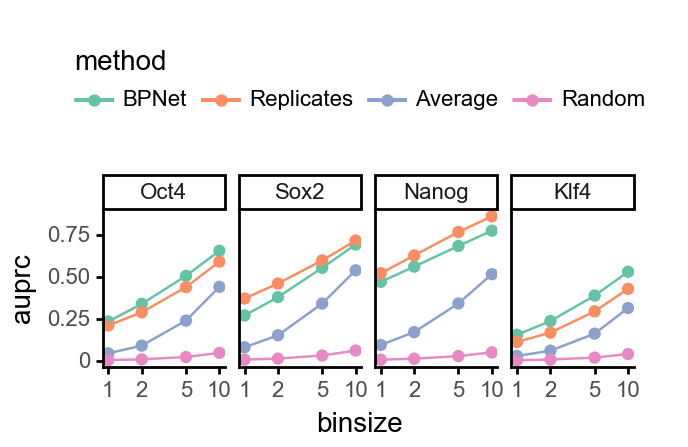

<ggplot: (-9223363251271900970)>

In [58]:
plotnine.options.figure_size = get_figsize(0.5, aspect=0.3)
fig = ggplot(aes(x='binsize', y='auprc', color='method'), data=df_auprc_tidy.groupby(['binsize', 'task', 'method']).auprc.mean().reset_index()) + \
  scale_x_log10(breaks=binsizes) + \
  geom_point() + \
  geom_line() + \
  facet_grid(".~task") + \
  theme_classic(base_size=10, base_family='Arial') +  \
  theme(legend_position='top') + \
  scale_color_brewer('qual', 7)
!mkdir -p {figures}/profile-metrics
fig.save(f"{figures}/profile-metrics/auprc.pdf")
fig.save(f"{figures}/profile-metrics/auprc.png", dpi=300)
fig

In [50]:
!mkdir -p {figures}/profile-metrics

### Scatterplot

In [78]:
def regression_eval(y_true, y_pred, alpha=0.5, markersize=2, task="", ax=None, same_lim=False, loglog=False):
    if ax is None:
        fig, ax = plt.subplots(1)
    from scipy.stats import pearsonr, spearmanr
    xmax = max([y_true.max(), y_pred.max()])
    xmin = min([y_true.min(), y_pred.min()])
    
    if loglog:
        pearson, pearson_pval = pearsonr(np.log10(y_true), np.log10(y_pred))
        spearman, spearman_pval = spearmanr(np.log10(y_true), np.log(y_pred))
    else:
        pearson, pearson_pval = pearsonr(y_true, y_pred)
        spearman, spearman_pval = spearmanr(y_true, y_pred)
    if loglog:
        plt_fn = ax.loglog
    else:
        plt_fn = ax.plot
        
    plt_fn(y_pred, y_true, ".", 
           markersize=markersize, 
           rasterized=True,
           alpha=alpha)
    ax.set_xlabel("Predicted")
    ax.set_ylabel("Observed")
    
    if same_lim:
        ax.set_xlim((xmin, xmax))
        ax.set_ylim((xmin, xmax))
    
    ax.set_title(task)
    ax.text(0.95, .01, f"R={spearman:.2f}",
            verticalalignment='bottom',
            horizontalalignment='right',
            fontsize=8,
            transform=ax.transAxes)

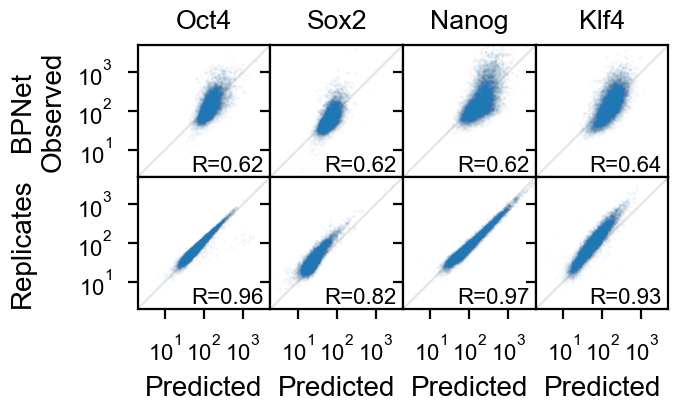

In [79]:
fig, axes = plt.subplots(2, len(tasks), figsize=get_figsize(frac=.5, aspect=2/len(tasks)),
                         sharex=True, sharey=True)
for i, task in enumerate(tasks):
    for j in range(2):
        ax = axes[j,i]
        
        if j == 0:
            # yp = np.exp(y_pred[f'{task}/counts'].mean(-1)*0.9)
            yp = np.exp(y_pred[f'{task}/counts'].mean(-1))
            # yt = y_true[f'{task}/counts'].mean(-1) + 1
            yt = np.exp(y_true[f'counts/{task}'].mean(-1))
        else:
            yt = test[task].sum(axis=1).mean(-1) + 1
            yp = train[task].sum(axis=1).mean(-1) + 1
        xrange = [2, 5e3]
        ax.set_ylim(xrange)
        ax.set_xlim(xrange)

        ax.plot(xrange, xrange, c='grey', alpha=0.2)
        regression_eval(yt, 
                        yp, alpha=.01, task=task if j == 0 else '', ax=ax, loglog=True)
        
        ax.xaxis.set_major_locator(ticker.LogLocator(base=10.0, numticks=3))
        ax.yaxis.set_major_locator(ticker.LogLocator(base=10.0, numticks=3))
        if i > 0:
            ax.set_ylabel("")
        else:
            ax.set_ylabel("BPNet\nObserved" if j==0 else "Replicates\n")
fig.subplots_adjust(wspace=0, hspace=0)
plt.minorticks_off()
# Save the figure
fig.savefig(f"{figures}/scatter/all.pdf", dpi=300)
# fig.savefig(f"{figures}/scatter/all.png")